# Vowel Detection Neural Network

## Introduction
1. Train a Feedforward Neural Networks to recognize a vowel based on Linear Predictive Coding (LPC) Coefficients (`LPC14`)
2. Dataset Pairs <`LPC14 Coefficients of vowels`, `1 Hot Encoding of Vowels`>
3. Hidden Layer Neural Network is variable to see which architecture best minimizes loss

## Step 0) Import Libraries and Dataset Constants

In [2]:
# PyTorch for feedforward NN architecture library
import torch
import torch.optim as optim

# Science Python library for loading matlab `.mat` files containing training data `ground_truth.mat` and `training_lpc.mat` 
import scipy.io

# Plotting libraries for analyzing the loss and accuracy of the model
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Training and Ground Truth Datset: Declared at the end of `Create_LPC_Data_Sets.m`
TRAINING_DATASET_PATH = "training_lpc1.mat"
TRAINING_DATASET_KEY = "training_lpc"

GROUND_TRUTH_DATASET_PATH = "ground_truth1.mat"
GROUND_TRUTH_DATASET_KEY = "ground_truth"

## Step 1) Import Training Data

In [4]:
# Load in Training Data from Matlab .mat file
training_data_with_meta_data = scipy.io.loadmat(TRAINING_DATASET_PATH)

In [5]:
# Note: `training_lpc` is a name we defined in Matlab
training_data = training_data_with_meta_data[TRAINING_DATASET_KEY]

In [6]:
# Load in Training Data from Matlab .mat file
ground_truth_with_meta_data = scipy.io.loadmat(GROUND_TRUTH_DATASET_PATH)

# Note: `training_lpc` is a name we defined in Matlab
ground_truth = ground_truth_with_meta_data[GROUND_TRUTH_DATASET_KEY]

In [8]:
# There are 218 training examples of LPC14
print(training_data.shape) 

(218, 14)


In [9]:
# There are 218 corresponding lables with a One Hot Encoding of length 10
print(ground_truth.shape) 

(218, 10)


## Step 2) Generate Model Architecture
- As we are trying to use different model architecture, we will use a function to encapsulate the model parameters

In [14]:
# Model Hyperparameters
LEARNING_RATE = 0.1
NUM_EPOCHS = 100000

# Model Architecture
INPUT_SIZE = training_data.shape[1]
OUTPUT_SIZE = ground_truth.shape[1]
HIDDEN_LAYER_SIZE = 10


In [15]:
def create_lpc_vowel_classifier(
    INPUT_SIZE: int,
    HIDDEN_LAYER_SIZE: int,
    ONE_HOT_ENCODING_SIZE: int,
    LEARNING_RATE: float
) -> tuple[torch.nn.Module, torch.optim.Optimizer]:
    """
    Creates a Feedforward Neural Network and an optimizer to improve the loss of the model.

    ## Parameters
    INPUT_SIZE: int
        Number of inputs to the NN (in our case, the number of LPCs)

    HIDDEN_LAYER_SIZE: int
        Number of inputs from Input to the Hidden Layer (variable for experimentation purposes)

    ONE_HOT_ENCODING_SIZE: int
        The final output layer's dimensions for the One Hot Encoding of the vowel

    LEARNING_RATE: float
        Learning Rate for the Stochastic Gradient Descent Optimizer    

    ## Returns
    model: torch.nn.Module
        feedforward NN with randomized weights and biases whose architecture is based on the function parameters
    optimzer: torch.optim.Optimizer
        Stochastic Gradient Descent object that uses the gradients calculated 
        by a `loss_function` to update the `model`'s weights and biases
    """

    # Step 1) Create the model architecture
    model = torch.nn.Sequential(
        # Layer 1
        torch.nn.Linear(INPUT_SIZE, HIDDEN_LAYER_SIZE),
        torch.nn.Sigmoid(),

        # Layer 2
        torch.nn.Linear(HIDDEN_LAYER_SIZE, ONE_HOT_ENCODING_SIZE),
        torch.nn.Softmax()
    )

    # Step 2) Create the Stochastic Gradient Descent object
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    return model, optimizer

In [16]:
# Build NN
training_tensor = torch.tensor(
    training_data, dtype=torch.float
)

ground_truth_tensor = torch.tensor(
    ground_truth, dtype=torch.float
)

model, optimizer = create_lpc_vowel_classifier(14, 3, 10, LEARNING_RATE=LEARNING_RATE)

# torch.nn.Sequential(
#     # Layer 1
#     torch.nn.Linear(training_tensor.shape[1], HIDDEN_LAYER_SIZE),
#     torch.nn.Sigmoid(),

#     torch.nn.Linear(HIDDEN_LAYER_SIZE, 3),
#     torch.nn.Sigmoid(),

#     # Layer 2
#     torch.nn.Linear(3, ground_truth_tensor.shape[1]),
#     # torch.nn.Sigmoid()
#     torch.nn.Softmax()
# )

loss_function = torch.nn.MSELoss(reduction='sum')
# loss_function = torch.nn.CrossEntropyLoss(reduction='sum')
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
loss_values = []

In [17]:
# Train Network

for i in range(NUM_EPOCHS):
# enumerate(
#     training_tensor, ground_truth
# ):
    vowel_prediction = model(training_tensor)
    loss = loss_function(vowel_prediction, ground_truth_tensor)
    loss_values.append(loss.item())
    
    if i % 1000 == 0:
        print(loss_values[i])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/Users/kyleng/B_Organized/A_School/Ling_487/clean_code/Vowel-Detection-NN/.librosa_venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


198.80755615234375
132.123779296875
128.23410034179688
133.909912109375
127.44490051269531
117.9389877319336
126.85155487060547
120.23551940917969
132.30592346191406
124.23489379882812
124.0602798461914
124.86640167236328
120.75428771972656
120.76634979248047
121.08500671386719
127.23091125488281
110.94969177246094
112.84476470947266
121.307373046875


KeyboardInterrupt: 

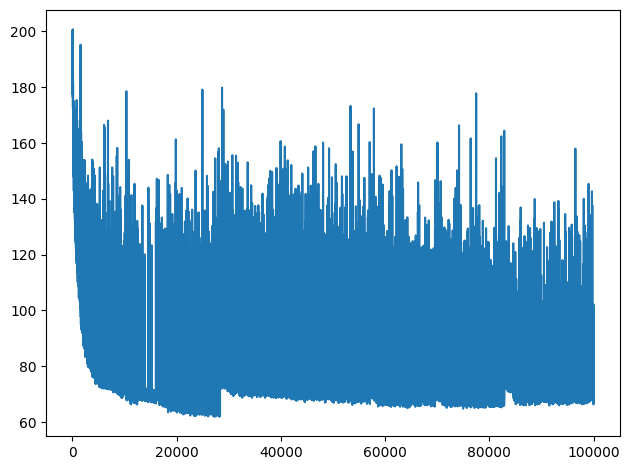

In [324]:
plt.figure()
plt.plot(loss_values)

/Users/kyleng/B_Organized/A_School/Ling_487/clean_code/Vowel-Detection-NN/.venv/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


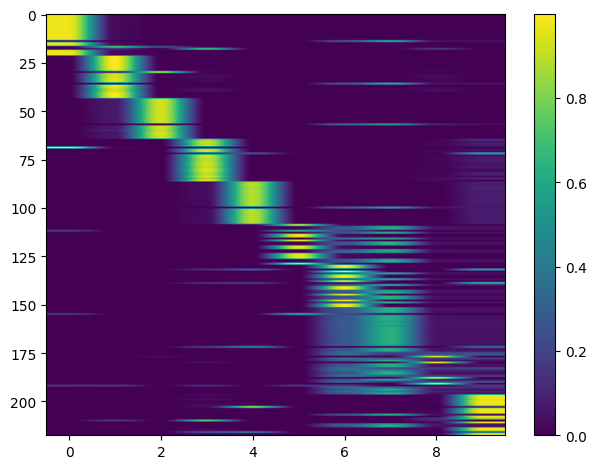

In [323]:
all_predictions = model(training_tensor)
plt.imshow(all_predictions.detach().numpy(), aspect='auto')
plt.colorbar()